In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
sns.set(color_codes=True)
import tensorflow as tf
import matplotlib.dates as md

from matplotlib import rc
from numpy.random import seed
from datetime import datetime
from datetime import timedelta
from pandas.plotting import autocorrelation_plot as auto_corr
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.dates import DateFormatter

%matplotlib inline
warnings.filterwarnings('ignore') 


In [2]:
from tensorflow.keras.layers import Input, Dropout, Dense, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [3]:
import collections
import warnings

import numpy as np

from tensorflow.python.distribute import distribution_strategy_context as ds_context
from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.saving.saved_model import layer_serialization
from tensorflow.python.keras.utils import control_flow_util
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.platform import tf_logging as logging
# from tensorflow.python.trackable import base as trackable
from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export
from tensorflow.tools.docs import doc_controls



@keras_export('keras.layers.StackedRNNCells')
class StackedRNNCells(Layer):
  def __init__(self, cells, **kwargs):
    for cell in cells:
      if not 'call' in dir(cell):
        raise ValueError('All cells must have a `call` method. '
                         'received cells:', cells)
      if not 'state_size' in dir(cell):
        raise ValueError('All cells must have a '
                         '`state_size` attribute. '
                         'received cells:', cells)
    self.cells = cells
    self.reverse_state_order = kwargs.pop('reverse_state_order', False)
    if self.reverse_state_order:
      logging.warning('reverse_state_order=True warning')
    super(StackedRNNCells, self).__init__(**kwargs)

  @property
  def state_size(self):
    return tuple(c.state_size for c in
                 (self.cells[::-1] if self.reverse_state_order else self.cells))

  @property
  def output_size(self):
    if getattr(self.cells[-1], 'output_size', None) is not None:
      return self.cells[-1].output_size
    elif _is_multiple_state(self.cells[-1].state_size):
      return self.cells[-1].state_size[0]
    else:
      return self.cells[-1].state_size

  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    initial_states = []
    for cell in self.cells[::-1] if self.reverse_state_order else self.cells:
      get_initial_state_fn = getattr(cell, 'get_initial_state', None)
      if get_initial_state_fn:
        initial_states.append(get_initial_state_fn(
            inputs=inputs, batch_size=batch_size, dtype=dtype))
      else:
        initial_states.append(_generate_zero_filled_state_for_cell(
            cell, inputs, batch_size, dtype))

    return tuple(initial_states)

  def call(self, inputs, states, constants=None, training=None, **kwargs):
    # Recover per-cell states.
    state_size = (self.state_size[::-1]
                  if self.reverse_state_order else self.state_size)
    nested_states = nest.pack_sequence_as(state_size, nest.flatten(states))

    new_nested_states = []
    for cell, states in zip(self.cells, nested_states):
      states = states if nest.is_nested(states) else [states]
      is_tf_rnn_cell = getattr(cell, '_is_tf_rnn_cell', None) is not None
      states = states[0] if len(states) == 1 and is_tf_rnn_cell else states
      if generic_utils.has_arg(cell.call, 'training'):
        kwargs['training'] = training
      else:
        kwargs.pop('training', None)
      cell_call_fn = cell.__call__ if callable(cell) else cell.call
      if generic_utils.has_arg(cell.call, 'constants'):
        inputs, states = cell_call_fn(inputs, states,
                                      constants=constants, **kwargs)
      else:
        inputs, states = cell_call_fn(inputs, states, **kwargs)
      new_nested_states.append(states)

    return inputs, nest.pack_sequence_as(state_size,
                                         nest.flatten(new_nested_states))

  @tf_utils.shape_type_conversion
  def build(self, input_shape):
    if isinstance(input_shape, list):
      input_shape = input_shape[0]
    for cell in self.cells:
      if isinstance(cell, Layer) and not cell.built:
        with backend.name_scope(cell.name):
          cell.build(input_shape)
          cell.built = True
      if getattr(cell, 'output_size', None) is not None:
        output_dim = cell.output_size
      elif _is_multiple_state(cell.state_size):
        output_dim = cell.state_size[0]
      else:
        output_dim = cell.state_size
      input_shape = tuple([input_shape[0]] +
                          tensor_shape.TensorShape(output_dim).as_list())
    self.built = True

  def get_config(self):
    cells = []
    for cell in self.cells:
      cells.append(generic_utils.serialize_keras_object(cell))
    config = {'cells': cells}
    base_config = super(StackedRNNCells, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config, custom_objects=None):
    from tensorflow.python.keras.layers import deserialize as deserialize_layer  # pylint: disable=g-import-not-at-top
    cells = []
    for cell_config in config.pop('cells'):
      cells.append(
          deserialize_layer(cell_config, custom_objects=custom_objects))
    return cls(cells, **config)


@keras_export('keras.layers.RNN')
class RNN(Layer):
  def __init__(self,
               cell,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               unroll=False,
               time_major=False,
               **kwargs):
    if isinstance(cell, (list, tuple)):
      cell = StackedRNNCells(cell)
    if not 'call' in dir(cell):
      raise ValueError('`cell` should have a `call` method. '
                       'The RNN was passed:', cell)
    if not 'state_size' in dir(cell):
      raise ValueError('No Size Defined')
    self.zero_output_for_mask = kwargs.pop('zero_output_for_mask', False)

    if 'input_shape' not in kwargs and (
        'input_dim' in kwargs or 'input_length' in kwargs):
      input_shape = (kwargs.pop('input_length', None),
                     kwargs.pop('input_dim', None))
      kwargs['input_shape'] = input_shape

    super(RNN, self).__init__(**kwargs)
    self.cell = cell
    self.return_sequences = return_sequences
    self.return_state = return_state
    self.go_backwards = go_backwards
    self.stateful = stateful
    self.unroll = unroll
    self.time_major = time_major

    self.supports_masking = True
    self.input_spec = None
    self.state_spec = None
    self._states = None
    self.constants_spec = None
    self._num_constants = 0

    if stateful:
      if ds_context.has_strategy():
        raise ValueError('RNNs with stateful=True not yet supported with '
                         'tf.distribute.Strategy.')

  @property
  def _use_input_spec_as_call_signature(self):
    if self.unroll:
      return False
    return super(RNN, self)._use_input_spec_as_call_signature

  @property
  def states(self):
    if self._states is None:
      state = nest.map_structure(lambda _: None, self.cell.state_size)
      return state if nest.is_nested(self.cell.state_size) else [state]
    return self._states

  @states.setter
  def states(self, states):
    self._states = states

  def compute_output_shape(self, input_shape):
    if isinstance(input_shape, list):
      input_shape = input_shape[0]
    try:
      input_shape = tensor_shape.TensorShape(input_shape)
    except (ValueError, TypeError):
      input_shape = nest.flatten(input_shape)[0]

    batch = input_shape[0]
    time_step = input_shape[1]
    if self.time_major:
      batch, time_step = time_step, batch

    if _is_multiple_state(self.cell.state_size):
      state_size = self.cell.state_size
    else:
      state_size = [self.cell.state_size]

    def _get_output_shape(flat_output_size):
      output_dim = tensor_shape.TensorShape(flat_output_size).as_list()
      if self.return_sequences:
        if self.time_major:
          output_shape = tensor_shape.TensorShape(
              [time_step, batch] + output_dim)
        else:
          output_shape = tensor_shape.TensorShape(
              [batch, time_step] + output_dim)
      else:
        output_shape = tensor_shape.TensorShape([batch] + output_dim)
      return output_shape

    if getattr(self.cell, 'output_size', None) is not None:
      # cell.output_size could be nested structure.
      output_shape = nest.flatten(nest.map_structure(
          _get_output_shape, self.cell.output_size))
      output_shape = output_shape[0] if len(output_shape) == 1 else output_shape
    else:
      output_shape = _get_output_shape(state_size[0])

    if self.return_state:
      def _get_state_shape(flat_state):
        state_shape = [batch] + tensor_shape.TensorShape(flat_state).as_list()
        return tensor_shape.TensorShape(state_shape)
      state_shape = nest.map_structure(_get_state_shape, state_size)
      return generic_utils.to_list(output_shape) + nest.flatten(state_shape)
    else:
      return output_shape

  def compute_mask(self, inputs, mask):
    mask = nest.flatten(mask)[0]
    output_mask = mask if self.return_sequences else None
    if self.return_state:
      state_mask = [None for _ in self.states]
      return [output_mask] + state_mask
    else:
      return output_mask

  def build(self, input_shape):
    if isinstance(input_shape, list):
      input_shape = input_shape[0]

    def get_input_spec(shape):
      if isinstance(shape, tensor_shape.TensorShape):
        input_spec_shape = shape.as_list()
      else:
        input_spec_shape = list(shape)
      batch_index, time_step_index = (1, 0) if self.time_major else (0, 1)
      if not self.stateful:
        input_spec_shape[batch_index] = None
      input_spec_shape[time_step_index] = None
      return InputSpec(shape=tuple(input_spec_shape))

    def get_step_input_shape(shape):
      if isinstance(shape, tensor_shape.TensorShape):
        shape = tuple(shape.as_list())
      return shape[1:] if self.time_major else (shape[0],) + shape[2:]

    try:
      input_shape = tensor_shape.TensorShape(input_shape)
    except (ValueError, TypeError):
      pass

    if not nest.is_nested(input_shape):
      if self.input_spec is not None:
        self.input_spec[0] = get_input_spec(input_shape)
      else:
        self.input_spec = [get_input_spec(input_shape)]
      step_input_shape = get_step_input_shape(input_shape)
    else:
      if self.input_spec is not None:
        self.input_spec[0] = nest.map_structure(get_input_spec, input_shape)
      else:
        self.input_spec = generic_utils.to_list(
            nest.map_structure(get_input_spec, input_shape))
      step_input_shape = nest.map_structure(get_step_input_shape, input_shape)

    # allow cell (if layer) to build before we set or validate state_spec.
    if isinstance(self.cell, Layer) and not self.cell.built:
      with backend.name_scope(self.cell.name):
        self.cell.build(step_input_shape)
        self.cell.built = True

    # set or validate state_spec
    if _is_multiple_state(self.cell.state_size):
      state_size = list(self.cell.state_size)
    else:
      state_size = [self.cell.state_size]

    if self.state_spec is not None:
      self._validate_state_spec(state_size, self.state_spec)
    else:
      self.state_spec = [
          InputSpec(shape=[None] + tensor_shape.TensorShape(dim).as_list())
          for dim in state_size
      ]
    if self.stateful:
      self.reset_states()
    self.built = True

  @staticmethod
  def _validate_state_spec(cell_state_sizes, init_state_specs):

    validation_error = ValueError(
        ' error '.format(init_state_specs, cell_state_sizes))
    flat_cell_state_sizes = nest.flatten(cell_state_sizes)
    flat_state_specs = nest.flatten(init_state_specs)

    if len(flat_cell_state_sizes) != len(flat_state_specs):
      raise validation_error
    for cell_state_spec, cell_state_size in zip(flat_state_specs,
                                                flat_cell_state_sizes):
      if not tensor_shape.TensorShape(
          # Ignore the first axis for init_state which is for batch
          cell_state_spec.shape[1:]).is_compatible_with(
              tensor_shape.TensorShape(cell_state_size)):
        raise validation_error

  @doc_controls.do_not_doc_inheritable
  def get_initial_state(self, inputs):
    get_initial_state_fn = getattr(self.cell, 'get_initial_state', None)

    if nest.is_nested(inputs):
      inputs = nest.flatten(inputs)[0]

    input_shape = array_ops.shape(inputs)
    batch_size = input_shape[1] if self.time_major else input_shape[0]
    dtype = inputs.dtype
    if get_initial_state_fn:
      init_state = get_initial_state_fn(
          inputs=None, batch_size=batch_size, dtype=dtype)
    else:
      init_state = _generate_zero_filled_state(batch_size, self.cell.state_size,
                                               dtype)
    if not nest.is_nested(init_state):
      init_state = [init_state]
    return list(init_state)

  def __call__(self, inputs, initial_state=None, constants=None, **kwargs):
    inputs, initial_state, constants = _standardize_args(inputs,
                                                         initial_state,
                                                         constants,
                                                         self._num_constants)

    if initial_state is None and constants is None:
      return super(RNN, self).__call__(inputs, **kwargs)

    additional_inputs = []
    additional_specs = []
    if initial_state is not None:
      additional_inputs += initial_state
      self.state_spec = nest.map_structure(
          lambda s: InputSpec(shape=backend.int_shape(s)), initial_state)
      additional_specs += self.state_spec
    if constants is not None:
      additional_inputs += constants
      self.constants_spec = [
          InputSpec(shape=backend.int_shape(constant)) for constant in constants
      ]
      self._num_constants = len(constants)
      additional_specs += self.constants_spec
    flat_additional_inputs = nest.flatten(additional_inputs)
    is_keras_tensor = backend.is_keras_tensor(
        flat_additional_inputs[0]) if flat_additional_inputs else True
    for tensor in flat_additional_inputs:
      if backend.is_keras_tensor(tensor) != is_keras_tensor:
        raise ValueError(' error ')

    if is_keras_tensor:
      full_input = [inputs] + additional_inputs
      if self.built:
        full_input_spec = self.input_spec + additional_specs
      else:
        full_input_spec = generic_utils.to_list(
            nest.map_structure(lambda _: None, inputs)) + additional_specs
      self.input_spec = full_input_spec
      output = super(RNN, self).__call__(full_input, **kwargs)
      self.input_spec = self.input_spec[:-len(additional_specs)]
      return output
    else:
      if initial_state is not None:
        kwargs['initial_state'] = initial_state
      if constants is not None:
        kwargs['constants'] = constants
      return super(RNN, self).__call__(inputs, **kwargs)

  def call(self,
           inputs,
           mask=None,
           training=None,
           initial_state=None,
           constants=None):
    inputs, row_lengths = backend.convert_inputs_if_ragged(inputs)
    is_ragged_input = (row_lengths is not None)
    self._validate_args_if_ragged(is_ragged_input, mask)

    inputs, initial_state, constants = self._process_inputs(
        inputs, initial_state, constants)

    self._maybe_reset_cell_dropout_mask(self.cell)
    if isinstance(self.cell, StackedRNNCells):
      for cell in self.cell.cells:
        self._maybe_reset_cell_dropout_mask(cell)

    if mask is not None:
      mask = nest.flatten(mask)[0]

    if nest.is_nested(inputs):
      input_shape = backend.int_shape(nest.flatten(inputs)[0])
    else:
      input_shape = backend.int_shape(inputs)
    timesteps = input_shape[0] if self.time_major else input_shape[1]
    if self.unroll and timesteps is None:
      raise ValueError('Cannot unroll a RNN if the time dimension is undefined.')

    kwargs = {}
    if generic_utils.has_arg(self.cell.call, 'training'):
      kwargs['training'] = training

    is_tf_rnn_cell = getattr(self.cell, '_is_tf_rnn_cell', None) is not None
    cell_call_fn = self.cell.__call__ if callable(self.cell) else self.cell.call
    if constants:
      if not generic_utils.has_arg(self.cell.call, 'constants'):
        raise ValueError('RNN cell does not support constants')

      def step(inputs, states):
        constants = states[-self._num_constants:]  # pylint: disable=invalid-unary-operand-type
        states = states[:-self._num_constants]  # pylint: disable=invalid-unary-operand-type

        states = states[0] if len(states) == 1 and is_tf_rnn_cell else states
        output, new_states = cell_call_fn(
            inputs, states, constants=constants, **kwargs)
        if not nest.is_nested(new_states):
          new_states = [new_states]
        return output, new_states
    else:

      def step(inputs, states):
        states = states[0] if len(states) == 1 and is_tf_rnn_cell else states
        output, new_states = cell_call_fn(inputs, states, **kwargs)
        if not nest.is_nested(new_states):
          new_states = [new_states]
        return output, new_states
    last_output, outputs, states = backend.rnn(
        step,
        inputs,
        initial_state,
        constants=constants,
        go_backwards=self.go_backwards,
        mask=mask,
        unroll=self.unroll,
        input_length=row_lengths if row_lengths is not None else timesteps,
        time_major=self.time_major,
        zero_output_for_mask=self.zero_output_for_mask)

    if self.stateful:
      updates = [
          state_ops.assign(self_state, state) for self_state, state in zip(
              nest.flatten(self.states), nest.flatten(states))
      ]
      self.add_update(updates)

    if self.return_sequences:
      output = backend.maybe_convert_to_ragged(
          is_ragged_input, outputs, row_lengths, go_backwards=self.go_backwards)
    else:
      output = last_output

    if self.return_state:
      if not isinstance(states, (list, tuple)):
        states = [states]
      else:
        states = list(states)
      return generic_utils.to_list(output) + states
    else:
      return output

  def _process_inputs(self, inputs, initial_state, constants):
    if (isinstance(inputs, collections.abc.Sequence) and not isinstance(inputs, tuple)):
      if not self._num_constants:
        initial_state = inputs[1:]
      else:
        initial_state = inputs[1:-self._num_constants]
        constants = inputs[-self._num_constants:]
      if len(initial_state) == 0:
        initial_state = None
      inputs = inputs[0]

    if self.stateful:
      if initial_state is not None:
        non_zero_count = math_ops.add_n([math_ops.count_nonzero_v2(s)
                                         for s in nest.flatten(self.states)])
        initial_state = control_flow_ops.cond(non_zero_count > 0,
                                              true_fn=lambda: self.states,
                                              false_fn=lambda: initial_state,
                                              strict=True)
      else:
        initial_state = self.states
    elif initial_state is None:
      initial_state = self.get_initial_state(inputs)

    if len(initial_state) != len(self.states):
      raise ValueError('Layer has ' + str(len(self.states)) +
                       ' states but was passed ' + str(len(initial_state)) +
                       ' initial states.')
    return inputs, initial_state, constants

  def _validate_args_if_ragged(self, is_ragged_input, mask):
    if not is_ragged_input:
      return

    if mask is not None:
      raise ValueError('The mask passed in was '+str(mask)+' and cant be applied to RaggedTensor inputs layers')
    if self.unroll:
      raise ValueError('RaggedTensors unrolling not supported')

  def _maybe_reset_cell_dropout_mask(self, cell):
    if isinstance(cell, DropoutRNNCellMixin):
      cell.reset_dropout_mask()
      cell.reset_recurrent_dropout_mask()

  def reset_states(self, states=None):

    if not self.stateful:
      raise AttributeError('Layer must be stateful.')
    spec_shape = None
    if self.input_spec is not None:
      spec_shape = nest.flatten(self.input_spec[0])[0].shape
    if spec_shape is None:
      batch_size = None
    else:
      batch_size = spec_shape[1] if self.time_major else spec_shape[0]
    if not batch_size:
      raise ValueError('error')
    # initialize state if None
    if nest.flatten(self.states)[0] is None:
      if getattr(self.cell, 'get_initial_state', None):
        flat_init_state_values = nest.flatten(self.cell.get_initial_state(
            inputs=None, batch_size=batch_size,
            dtype=self.dtype or backend.floatx()))
      else:
        flat_init_state_values = nest.flatten(_generate_zero_filled_state(
            batch_size, self.cell.state_size, self.dtype or backend.floatx()))
      flat_states_variables = nest.map_structure(
          backend.variable, flat_init_state_values)
      self.states = nest.pack_sequence_as(self.cell.state_size,
                                          flat_states_variables)
      if not nest.is_nested(self.states):
        self.states = [self.states]
    elif states is None:
      for state, size in zip(nest.flatten(self.states),
                             nest.flatten(self.cell.state_size)):
        backend.set_value(
            state,
            np.zeros([batch_size] + tensor_shape.TensorShape(size).as_list()))
    else:
      flat_states = nest.flatten(self.states)
      flat_input_states = nest.flatten(states)
      if len(flat_input_states) != len(flat_states):
        raise ValueError('Layer ' + self.name + ' expects ' +
                         str(len(flat_states)) + ' states, '
                         'but it received ' + str(len(flat_input_states)) +
                         ' state values. Input received: ' + str(states))
      set_value_tuples = []
      for i, (value, state) in enumerate(zip(flat_input_states,
                                             flat_states)):
        if value.shape != state.shape:
          raise ValueError(
              'State ' + str(i) + ' is incompatible with layer ' +
              self.name + ': expected shape=' + str(
                  (batch_size, state)) + ', found shape=' + str(value.shape))
        set_value_tuples.append((state, value))
      backend.batch_set_value(set_value_tuples)

  def get_config(self):
    config = {
        'return_sequences': self.return_sequences,
        'return_state': self.return_state,
        'go_backwards': self.go_backwards,
        'stateful': self.stateful,
        'unroll': self.unroll,
        'time_major': self.time_major
    }
    if self._num_constants:
      config['num_constants'] = self._num_constants
    if self.zero_output_for_mask:
      config['zero_output_for_mask'] = self.zero_output_for_mask

    config['cell'] = generic_utils.serialize_keras_object(self.cell)
    base_config = super(RNN, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config, custom_objects=None):
    from tensorflow.python.keras.layers import deserialize as deserialize_layer  # pylint: disable=g-import-not-at-top
    cell = deserialize_layer(config.pop('cell'), custom_objects=custom_objects)
    num_constants = config.pop('num_constants', 0)
    layer = cls(cell, **config)
    layer._num_constants = num_constants
    return layer

  @property
  def _trackable_saved_model_saver(self):
    return layer_serialization.RNNSavedModelSaver(self)

@doc_controls.do_not_generate_docs
class DropoutRNNCellMixin(object):


  def __init__(self, *args, **kwargs):
    self._create_non_trackable_mask_cache()
    super(DropoutRNNCellMixin, self).__init__(*args, **kwargs)

  def _create_non_trackable_mask_cache(self):

    self._dropout_mask_cache = backend.ContextValueCache(
        self._create_dropout_mask)
    self._recurrent_dropout_mask_cache = backend.ContextValueCache(
        self._create_recurrent_dropout_mask)

  def reset_dropout_mask(self):

    self._dropout_mask_cache.clear()

  def reset_recurrent_dropout_mask(self):

    self._recurrent_dropout_mask_cache.clear()

  def _create_dropout_mask(self, inputs, training, count=1):
    return _generate_dropout_mask(
        array_ops.ones_like(inputs),
        self.dropout,
        training=training,
        count=count)

  def _create_recurrent_dropout_mask(self, inputs, training, count=1):
    return _generate_dropout_mask(
        array_ops.ones_like(inputs),
        self.recurrent_dropout,
        training=training,
        count=count)

  def get_dropout_mask_for_cell(self, inputs, training, count=1):

    if self.dropout == 0:
      return None
    init_kwargs = dict(inputs=inputs, training=training, count=count)
    return self._dropout_mask_cache.setdefault(kwargs=init_kwargs)

  def get_recurrent_dropout_mask_for_cell(self, inputs, training, count=1):

    if self.recurrent_dropout == 0:
      return None
    init_kwargs = dict(inputs=inputs, training=training, count=count)
    return self._recurrent_dropout_mask_cache.setdefault(kwargs=init_kwargs)

  def __getstate__(self):
    state = super(DropoutRNNCellMixin, self).__getstate__()
    state.pop('_dropout_mask_cache', None)
    state.pop('_recurrent_dropout_mask_cache', None)
    return state

  def __setstate__(self, state):
    state['_dropout_mask_cache'] = backend.ContextValueCache(
        self._create_dropout_mask)
    state['_recurrent_dropout_mask_cache'] = backend.ContextValueCache(
        self._create_recurrent_dropout_mask)
    super(DropoutRNNCellMixin, self).__setstate__(state)


@keras_export('keras.layers.SimpleRNNCell')
class SimpleRNNCell(DropoutRNNCellMixin, Layer):

  def __init__(self,
               units,
               activation='tanh',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    if units < 0:
      raise ValueError(f'error')
    # By default use cached variable under v2 mode, see b/143699808.
    if ops.executing_eagerly_outside_functions():
      self._enable_caching_device = kwargs.pop('enable_caching_device', True)
    else:
      self._enable_caching_device = kwargs.pop('enable_caching_device', False)
    super(SimpleRNNCell, self).__init__(**kwargs)
    self.units = units
    self.activation = activations.get(activation)
    self.use_bias = use_bias

    self.kernel_initializer = initializers.get(kernel_initializer)
    self.recurrent_initializer = initializers.get(recurrent_initializer)
    self.bias_initializer = initializers.get(bias_initializer)

    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)

    self.kernel_constraint = constraints.get(kernel_constraint)
    self.recurrent_constraint = constraints.get(recurrent_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

    self.dropout = min(1., max(0., dropout))
    self.recurrent_dropout = min(1., max(0., recurrent_dropout))
    self.state_size = self.units
    self.output_size = self.units

  @tf_utils.shape_type_conversion
  def build(self, input_shape):
    default_caching_device = _caching_device(self)
    self.kernel = self.add_weight(
        shape=(input_shape[-1], self.units),
        name='kernel',
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        caching_device=default_caching_device)
    self.recurrent_kernel = self.add_weight(
        shape=(self.units, self.units),
        name='recurrent_kernel',
        initializer=self.recurrent_initializer,
        regularizer=self.recurrent_regularizer,
        constraint=self.recurrent_constraint,
        caching_device=default_caching_device)
    if self.use_bias:
      self.bias = self.add_weight(
          shape=(self.units,),
          name='bias',
          initializer=self.bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint,
          caching_device=default_caching_device)
    else:
      self.bias = None
    self.built = True

  def call(self, inputs, states, training=None):
    prev_output = states[0] if nest.is_nested(states) else states
    dp_mask = self.get_dropout_mask_for_cell(inputs, training)
    rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        prev_output, training)

    if dp_mask is not None:
      h = backend.dot(inputs * dp_mask, self.kernel)
    else:
      h = backend.dot(inputs, self.kernel)
    if self.bias is not None:
      h = backend.bias_add(h, self.bias)

    if rec_dp_mask is not None:
      prev_output = prev_output * rec_dp_mask
    output = h + backend.dot(prev_output, self.recurrent_kernel)
    if self.activation is not None:
      output = self.activation(output)

    new_state = [output] if nest.is_nested(states) else output
    return output, new_state

  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    return _generate_zero_filled_state_for_cell(self, inputs, batch_size, dtype)

  def get_config(self):
    config = {
        'units':
            self.units,
        'activation':
            activations.serialize(self.activation),
        'use_bias':
            self.use_bias,
        'kernel_initializer':
            initializers.serialize(self.kernel_initializer),
        'recurrent_initializer':
            initializers.serialize(self.recurrent_initializer),
        'bias_initializer':
            initializers.serialize(self.bias_initializer),
        'kernel_regularizer':
            regularizers.serialize(self.kernel_regularizer),
        'recurrent_regularizer':
            regularizers.serialize(self.recurrent_regularizer),
        'bias_regularizer':
            regularizers.serialize(self.bias_regularizer),
        'kernel_constraint':
            constraints.serialize(self.kernel_constraint),
        'recurrent_constraint':
            constraints.serialize(self.recurrent_constraint),
        'bias_constraint':
            constraints.serialize(self.bias_constraint),
        'dropout':
            self.dropout,
        'recurrent_dropout':
            self.recurrent_dropout
    }
    config.update(_config_for_enable_caching_device(self))
    base_config = super(SimpleRNNCell, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


@keras_export('keras.layers.SimpleRNN')
class SimpleRNN(RNN):

  def __init__(self,
               units,
               activation='tanh',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               unroll=False,
               **kwargs):
    if 'implementation' in kwargs:
      kwargs.pop('implementation')
      logging.warning('warning')
    if 'enable_caching_device' in kwargs:
      cell_kwargs = {'enable_caching_device':
                     kwargs.pop('enable_caching_device')}
    else:
      cell_kwargs = {}
    cell = SimpleRNNCell(
        units,
        activation=activation,
        use_bias=use_bias,
        kernel_initializer=kernel_initializer,
        recurrent_initializer=recurrent_initializer,
        bias_initializer=bias_initializer,
        kernel_regularizer=kernel_regularizer,
        recurrent_regularizer=recurrent_regularizer,
        bias_regularizer=bias_regularizer,
        kernel_constraint=kernel_constraint,
        recurrent_constraint=recurrent_constraint,
        bias_constraint=bias_constraint,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout,
        dtype=kwargs.get('dtype'),
        trainable=kwargs.get('trainable', True),
        **cell_kwargs)
    super(SimpleRNN, self).__init__(
        cell,
        return_sequences=return_sequences,
        return_state=return_state,
        go_backwards=go_backwards,
        stateful=stateful,
        unroll=unroll,
        **kwargs)
    self.activity_regularizer = regularizers.get(activity_regularizer)
    self.input_spec = [InputSpec(ndim=3)]

  def call(self, inputs, mask=None, training=None, initial_state=None):
    return super(SimpleRNN, self).call(
        inputs, mask=mask, training=training, initial_state=initial_state)

  @property
  def units(self):
    return self.cell.units

  @property
  def activation(self):
    return self.cell.activation

  @property
  def use_bias(self):
    return self.cell.use_bias

  @property
  def kernel_initializer(self):
    return self.cell.kernel_initializer

  @property
  def recurrent_initializer(self):
    return self.cell.recurrent_initializer

  @property
  def bias_initializer(self):
    return self.cell.bias_initializer

  @property
  def kernel_regularizer(self):
    return self.cell.kernel_regularizer

  @property
  def recurrent_regularizer(self):
    return self.cell.recurrent_regularizer

  @property
  def bias_regularizer(self):
    return self.cell.bias_regularizer

  @property
  def kernel_constraint(self):
    return self.cell.kernel_constraint

  @property
  def recurrent_constraint(self):
    return self.cell.recurrent_constraint

  @property
  def bias_constraint(self):
    return self.cell.bias_constraint

  @property
  def dropout(self):
    return self.cell.dropout

  @property
  def recurrent_dropout(self):
    return self.cell.recurrent_dropout

  def get_config(self):
    config = {
        'units':
            self.units,
        'activation':
            activations.serialize(self.activation),
        'use_bias':
            self.use_bias,
        'kernel_initializer':
            initializers.serialize(self.kernel_initializer),
        'recurrent_initializer':
            initializers.serialize(self.recurrent_initializer),
        'bias_initializer':
            initializers.serialize(self.bias_initializer),
        'kernel_regularizer':
            regularizers.serialize(self.kernel_regularizer),
        'recurrent_regularizer':
            regularizers.serialize(self.recurrent_regularizer),
        'bias_regularizer':
            regularizers.serialize(self.bias_regularizer),
        'activity_regularizer':
            regularizers.serialize(self.activity_regularizer),
        'kernel_constraint':
            constraints.serialize(self.kernel_constraint),
        'recurrent_constraint':
            constraints.serialize(self.recurrent_constraint),
        'bias_constraint':
            constraints.serialize(self.bias_constraint),
        'dropout':
            self.dropout,
        'recurrent_dropout':
            self.recurrent_dropout
    }
    base_config = super(SimpleRNN, self).get_config()
    config.update(_config_for_enable_caching_device(self.cell))
    del base_config['cell']
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config):
    if 'implementation' in config:
      config.pop('implementation')
    return cls(**config)

@keras_export(v1=['keras.layers.LSTMCell'])
class LSTMCell(DropoutRNNCellMixin, Layer):

  def __init__(self,
               units,
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    if units < 0:
      raise ValueError(f'error')
    # By default use cached variable under v2 mode, see b/143699808.
    if ops.executing_eagerly_outside_functions():
      self._enable_caching_device = kwargs.pop('enable_caching_device', True)
    else:
      self._enable_caching_device = kwargs.pop('enable_caching_device', False)
    super(LSTMCell, self).__init__(**kwargs)
    self.units = units
    self.activation = activations.get(activation)
    self.recurrent_activation = activations.get(recurrent_activation)
    self.use_bias = use_bias

    self.kernel_initializer = initializers.get(kernel_initializer)
    self.recurrent_initializer = initializers.get(recurrent_initializer)
    self.bias_initializer = initializers.get(bias_initializer)
    self.unit_forget_bias = unit_forget_bias

    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)

    self.kernel_constraint = constraints.get(kernel_constraint)
    self.recurrent_constraint = constraints.get(recurrent_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

    self.dropout = min(1., max(0., dropout))
    self.recurrent_dropout = min(1., max(0., recurrent_dropout))
    implementation = kwargs.pop('implementation', 1)
    if self.recurrent_dropout != 0 and implementation != 1:
      self.implementation = 1
    else:
      self.implementation = implementation
    self.state_size = [self.units, self.units]
    self.output_size = self.units

  @tf_utils.shape_type_conversion
  def build(self, input_shape):
    default_caching_device = _caching_device(self)
    input_dim = input_shape[-1]
    self.kernel = self.add_weight(
        shape=(input_dim, self.units * 4),
        name='kernel',
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        caching_device=default_caching_device)
    self.recurrent_kernel = self.add_weight(
        shape=(self.units, self.units * 4),
        name='recurrent_kernel',
        initializer=self.recurrent_initializer,
        regularizer=self.recurrent_regularizer,
        constraint=self.recurrent_constraint,
        caching_device=default_caching_device)

    if self.use_bias:
      if self.unit_forget_bias:

        def bias_initializer(_, *args, **kwargs):
          return backend.concatenate([
              self.bias_initializer((self.units,), *args, **kwargs),
              initializers.get('ones')((self.units,), *args, **kwargs),
              self.bias_initializer((self.units * 2,), *args, **kwargs),
          ])
      else:
        bias_initializer = self.bias_initializer
      self.bias = self.add_weight(
          shape=(self.units * 4,),
          name='bias',
          initializer=bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint,
          caching_device=default_caching_device)
    else:
      self.bias = None
    self.built = True

  def _compute_carry_and_output(self, x, h_tm1, c_tm1):
    x_i, x_f, x_c, x_o = x
    h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o = h_tm1
    i = self.recurrent_activation(
        x_i + backend.dot(h_tm1_i, self.recurrent_kernel[:, :self.units]))
    f = self.recurrent_activation(x_f + backend.dot(
        h_tm1_f, self.recurrent_kernel[:, self.units:self.units * 2]))
    c = f * c_tm1 + i * self.activation(x_c + backend.dot(
        h_tm1_c, self.recurrent_kernel[:, self.units * 2:self.units * 3]))
    o = self.recurrent_activation(
        x_o + backend.dot(h_tm1_o, self.recurrent_kernel[:, self.units * 3:]))
    return c, o

  def _compute_carry_and_output_fused(self, z, c_tm1):
    z0, z1, z2, z3 = z
    i = self.recurrent_activation(z0)
    f = self.recurrent_activation(z1)
    c = f * c_tm1 + i * self.activation(z2)
    o = self.recurrent_activation(z3)
    return c, o

  def call(self, inputs, states, training=None):
    h_tm1 = states[0]  # previous memory state
    c_tm1 = states[1]  # previous carry state

    dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=4)
    rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        h_tm1, training, count=4)

    if self.implementation == 1:
      if 0 < self.dropout < 1.:
        inputs_i = inputs * dp_mask[0]
        inputs_f = inputs * dp_mask[1]
        inputs_c = inputs * dp_mask[2]
        inputs_o = inputs * dp_mask[3]
      else:
        inputs_i = inputs
        inputs_f = inputs
        inputs_c = inputs
        inputs_o = inputs
      k_i, k_f, k_c, k_o = array_ops.split(
          self.kernel, num_or_size_splits=4, axis=1)
      x_i = backend.dot(inputs_i, k_i)
      x_f = backend.dot(inputs_f, k_f)
      x_c = backend.dot(inputs_c, k_c)
      x_o = backend.dot(inputs_o, k_o)
      if self.use_bias:
        b_i, b_f, b_c, b_o = array_ops.split(
            self.bias, num_or_size_splits=4, axis=0)
        x_i = backend.bias_add(x_i, b_i)
        x_f = backend.bias_add(x_f, b_f)
        x_c = backend.bias_add(x_c, b_c)
        x_o = backend.bias_add(x_o, b_o)

      if 0 < self.recurrent_dropout < 1.:
        h_tm1_i = h_tm1 * rec_dp_mask[0]
        h_tm1_f = h_tm1 * rec_dp_mask[1]
        h_tm1_c = h_tm1 * rec_dp_mask[2]
        h_tm1_o = h_tm1 * rec_dp_mask[3]
      else:
        h_tm1_i = h_tm1
        h_tm1_f = h_tm1
        h_tm1_c = h_tm1
        h_tm1_o = h_tm1
      x = (x_i, x_f, x_c, x_o)
      h_tm1 = (h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o)
      c, o = self._compute_carry_and_output(x, h_tm1, c_tm1)
    else:
      if 0. < self.dropout < 1.:
        inputs = inputs * dp_mask[0]
      z = backend.dot(inputs, self.kernel)
      z += backend.dot(h_tm1, self.recurrent_kernel)
      if self.use_bias:
        z = backend.bias_add(z, self.bias)

      z = array_ops.split(z, num_or_size_splits=4, axis=1)
      c, o = self._compute_carry_and_output_fused(z, c_tm1)

    h = o * self.activation(c)
    return h, [h, c]

  def get_config(self):
    config = {
        'units':
            self.units,
        'activation':
            activations.serialize(self.activation),
        'recurrent_activation':
            activations.serialize(self.recurrent_activation),
        'use_bias':
            self.use_bias,
        'kernel_initializer':
            initializers.serialize(self.kernel_initializer),
        'recurrent_initializer':
            initializers.serialize(self.recurrent_initializer),
        'bias_initializer':
            initializers.serialize(self.bias_initializer),
        'unit_forget_bias':
            self.unit_forget_bias,
        'kernel_regularizer':
            regularizers.serialize(self.kernel_regularizer),
        'recurrent_regularizer':
            regularizers.serialize(self.recurrent_regularizer),
        'bias_regularizer':
            regularizers.serialize(self.bias_regularizer),
        'kernel_constraint':
            constraints.serialize(self.kernel_constraint),
        'recurrent_constraint':
            constraints.serialize(self.recurrent_constraint),
        'bias_constraint':
            constraints.serialize(self.bias_constraint),
        'dropout':
            self.dropout,
        'recurrent_dropout':
            self.recurrent_dropout,
        'implementation':
            self.implementation
    }
    config.update(_config_for_enable_caching_device(self))
    base_config = super(LSTMCell, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    return list(_generate_zero_filled_state_for_cell(
        self, inputs, batch_size, dtype))

@keras_export(v1=['keras.layers.LSTM'])
class LSTM(RNN):

  def __init__(self,
               units,
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               unroll=False,
               **kwargs):
    implementation = kwargs.pop('implementation', 1)
    if implementation == 0:
      logging.warning('warning')
    if 'enable_caching_device' in kwargs:
      cell_kwargs = {'enable_caching_device':
                     kwargs.pop('enable_caching_device')}
    else:
      cell_kwargs = {}
    cell = LSTMCell(
        units,
        activation=activation,
        recurrent_activation=recurrent_activation,
        use_bias=use_bias,
        kernel_initializer=kernel_initializer,
        recurrent_initializer=recurrent_initializer,
        unit_forget_bias=unit_forget_bias,
        bias_initializer=bias_initializer,
        kernel_regularizer=kernel_regularizer,
        recurrent_regularizer=recurrent_regularizer,
        bias_regularizer=bias_regularizer,
        kernel_constraint=kernel_constraint,
        recurrent_constraint=recurrent_constraint,
        bias_constraint=bias_constraint,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout,
        implementation=implementation,
        dtype=kwargs.get('dtype'),
        trainable=kwargs.get('trainable', True),
        **cell_kwargs)
    super(LSTM, self).__init__(
        cell,
        return_sequences=return_sequences,
        return_state=return_state,
        go_backwards=go_backwards,
        stateful=stateful,
        unroll=unroll,
        **kwargs)
    self.activity_regularizer = regularizers.get(activity_regularizer)
    self.input_spec = [InputSpec(ndim=3)]

  def call(self, inputs, mask=None, training=None, initial_state=None):
    return super(LSTM, self).call(
        inputs, mask=mask, training=training, initial_state=initial_state)

  @property
  def units(self):
    return self.cell.units

  @property
  def activation(self):
    return self.cell.activation

  @property
  def recurrent_activation(self):
    return self.cell.recurrent_activation

  @property
  def use_bias(self):
    return self.cell.use_bias

  @property
  def kernel_initializer(self):
    return self.cell.kernel_initializer

  @property
  def recurrent_initializer(self):
    return self.cell.recurrent_initializer

  @property
  def bias_initializer(self):
    return self.cell.bias_initializer

  @property
  def unit_forget_bias(self):
    return self.cell.unit_forget_bias

  @property
  def kernel_regularizer(self):
    return self.cell.kernel_regularizer

  @property
  def recurrent_regularizer(self):
    return self.cell.recurrent_regularizer

  @property
  def bias_regularizer(self):
    return self.cell.bias_regularizer

  @property
  def kernel_constraint(self):
    return self.cell.kernel_constraint

  @property
  def recurrent_constraint(self):
    return self.cell.recurrent_constraint

  @property
  def bias_constraint(self):
    return self.cell.bias_constraint

  @property
  def dropout(self):
    return self.cell.dropout

  @property
  def recurrent_dropout(self):
    return self.cell.recurrent_dropout

  @property
  def implementation(self):
    return self.cell.implementation

  def get_config(self):
    config = {
        'units':
            self.units,
        'activation':
            activations.serialize(self.activation),
        'recurrent_activation':
            activations.serialize(self.recurrent_activation),
        'use_bias':
            self.use_bias,
        'kernel_initializer':
            initializers.serialize(self.kernel_initializer),
        'recurrent_initializer':
            initializers.serialize(self.recurrent_initializer),
        'bias_initializer':
            initializers.serialize(self.bias_initializer),
        'unit_forget_bias':
            self.unit_forget_bias,
        'kernel_regularizer':
            regularizers.serialize(self.kernel_regularizer),
        'recurrent_regularizer':
            regularizers.serialize(self.recurrent_regularizer),
        'bias_regularizer':
            regularizers.serialize(self.bias_regularizer),
        'activity_regularizer':
            regularizers.serialize(self.activity_regularizer),
        'kernel_constraint':
            constraints.serialize(self.kernel_constraint),
        'recurrent_constraint':
            constraints.serialize(self.recurrent_constraint),
        'bias_constraint':
            constraints.serialize(self.bias_constraint),
        'dropout':
            self.dropout,
        'recurrent_dropout':
            self.recurrent_dropout,
        'implementation':
            self.implementation
    }
    config.update(_config_for_enable_caching_device(self.cell))
    base_config = super(LSTM, self).get_config()
    del base_config['cell']
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config):
    if 'implementation' in config and config['implementation'] == 0:
      config['implementation'] = 1
    return cls(**config)


def _generate_dropout_mask(ones, rate, training=None, count=1):
  def dropped_inputs():
    return backend.dropout(ones, rate)

  if count > 1:
    return [
        backend.in_train_phase(dropped_inputs, ones, training=training)
        for _ in range(count)
    ]
  return backend.in_train_phase(dropped_inputs, ones, training=training)


def _standardize_args(inputs, initial_state, constants, num_constants):

  if isinstance(inputs, list):
    assert initial_state is None and constants is None
    if num_constants:
      constants = inputs[-num_constants:]
      inputs = inputs[:-num_constants]
    if len(inputs) > 1:
      initial_state = inputs[1:]
      inputs = inputs[:1]

    if len(inputs) > 1:
      inputs = tuple(inputs)
    else:
      inputs = inputs[0]

  def to_list_or_none(x):
    if x is None or isinstance(x, list):
      return x
    if isinstance(x, tuple):
      return list(x)
    return [x]

  initial_state = to_list_or_none(initial_state)
  constants = to_list_or_none(constants)

  return inputs, initial_state, constants


def _is_multiple_state(state_size):
  return (hasattr(state_size, '__len__') and
          not isinstance(state_size, tensor_shape.TensorShape))


def _generate_zero_filled_state_for_cell(cell, inputs, batch_size, dtype):
  if inputs is not None:
    batch_size = array_ops.shape(inputs)[0]
    dtype = inputs.dtype
  return _generate_zero_filled_state(batch_size, cell.state_size, dtype)


def _generate_zero_filled_state(batch_size_tensor, state_size, dtype):
  if batch_size_tensor is None or dtype is None:
    raise ValueError(
        'error'.format(batch_size_tensor, dtype))

  def create_zeros(unnested_state_size):
    flat_dims = tensor_shape.TensorShape(unnested_state_size).as_list()
    init_state_size = [batch_size_tensor] + flat_dims
    return array_ops.zeros(init_state_size, dtype=dtype)

  if nest.is_nested(state_size):
    return nest.map_structure(create_zeros, state_size)
  else:
    return create_zeros(state_size)


def _caching_device(rnn_cell):

  if context.executing_eagerly():
    return None
  if not getattr(rnn_cell, '_enable_caching_device', False):
    return None
  if control_flow_util.IsInWhileLoop(ops.get_default_graph()):
    logging.warning(
        'warning')
    return None
  if (rnn_cell._dtype_policy.compute_dtype !=
      rnn_cell._dtype_policy.variable_dtype):
    logging.warning(
        'warning')
    return None
  return lambda op: op.device

def _config_for_enable_caching_device(rnn_cell):
  default_enable_caching_device = ops.executing_eagerly_outside_functions()
  if rnn_cell._enable_caching_device != default_enable_caching_device:
    return {'enable_caching_device': rnn_cell._enable_caching_device}
  return {}

In [4]:
# set random seed
seed(10)
tf.random.set_seed(10)

In [5]:
data = pd.read_csv('/content/sample_data/walmart_cleaned.csv')
data.head()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [6]:
data.describe().round().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,421570.000000,211611.000000,122195.000000,0.000000,105782.000000,211604.000000,317425.000000,423285.000000
Store,421570.000000,22.000000,13.000000,1.000000,11.000000,22.000000,33.000000,45.000000
IsHoliday,421570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Dept,421570.000000,44.000000,30.000000,1.000000,18.000000,37.000000,74.000000,99.000000
Weekly_Sales,421570.000000,15981.000000,22711.000000,-4989.000000,2080.000000,7612.000000,20206.000000,693099.000000
Temperature,421570.000000,60.000000,18.000000,-2.000000,47.000000,62.000000,74.000000,100.000000
Fuel_Price,421570.000000,3.000000,0.000000,2.000000,3.000000,3.000000,4.000000,4.000000
MarkDown1,421570.000000,2590.000000,6052.000000,0.000000,0.000000,0.000000,2809.000000,88647.000000
MarkDown2,421570.000000,880.000000,5085.000000,-266.000000,0.000000,0.000000,2.000000,104520.000000
MarkDown3,421570.000000,468.000000,5529.000000,-29.000000,0.000000,0.000000,5.000000,141631.000000


In [7]:
data['Date'] = pd.to_datetime(data['Date'])

In [8]:
store_dept_table = pd.pivot_table(data, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


In [9]:
data.loc[data['Weekly_Sales']<=0]

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
182,182,1,2010-02-19,0,47.0,-863.00,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,3,151315
429,429,1,2010-03-12,0,47.0,-698.00,57.79,2.667,0.00,0.00,0.00,0.00,0.00,211.380643,8.106,3,151315
2555,2555,1,2010-10-08,0,47.0,-58.00,63.93,2.633,0.00,0.00,0.00,0.00,0.00,211.746754,7.838,3,151315
3632,3632,1,2011-01-21,0,54.0,-50.00,44.04,3.016,0.00,0.00,0.00,0.00,0.00,211.827234,7.742,3,151315
4109,4109,1,2011-03-11,0,47.0,0.00,53.56,3.459,0.00,0.00,0.00,0.00,0.00,214.111056,7.742,3,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420031,421747,45,2012-05-25,0,49.0,-4.97,67.21,3.798,5370.39,0.00,361.22,1287.62,2461.81,191.002810,8.567,2,118221
420370,422086,45,2012-06-29,0,49.0,-34.00,75.22,3.506,3291.36,425.60,0.00,314.88,2255.34,191.099246,8.567,2,118221
420736,422452,45,2012-08-03,0,49.0,-1.91,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,2,118221
421016,422732,45,2012-08-31,0,54.0,0.00,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,2,118221


In [10]:
data2 = data.loc[data['Weekly_Sales'] > 0]


In [11]:
data2['Date'].head(5).append(data2['Date'].tail(5)) # to see first and last 5 rows

0        2010-02-05
1        2010-02-05
2        2010-02-05
3        2010-02-05
4        2010-02-05
421565   2012-10-26
421566   2012-10-26
421567   2012-10-26
421568   2012-10-26
421569   2012-10-26
Name: Date, dtype: datetime64[ns]

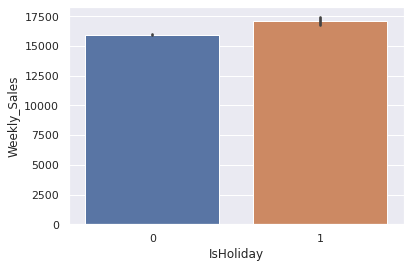

In [12]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=data2)

In [13]:
df= data2.copy()

In [14]:
df.set_index('Date', inplace=True)

In [15]:
df1 = df.resample('W-MON').sum()
#df.resample('W-MON')
#.interpolate()[::7]

In [16]:
df1


,Unnamed: 0,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,,
2010-02-08,604946596,64931,0,130099.0,49750875.98,98051.13,8007.134,0.00,0.00,0.00,0.00,0.00,492949.905535,25272.533,7106,404726444
2010-02-15,604785266,64897,2949,130734.0,48336800.10,98409.44,7950.372,0.00,0.00,0.00,0.00,0.00,493668.382611,25266.603,7122,406003811
2010-02-22,610391383,65472,0,131534.0,48277902.33,109986.81,7940.313,0.00,0.00,0.00,0.00,0.00,497137.036639,25466.540,7164,407715096
2010-03-01,603712495,64742,0,129533.0,43970440.65,113556.93,7895.330,0.00,0.00,0.00,0.00,0.00,493062.204817,25172.556,7092,403855974
2010-03-08,604069157,64757,0,129242.0,46872715.16,124390.95,8020.926,0.00,0.00,0.00,0.00,0.00,492308.584801,25172.941,7088,403865218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-01,638518858,65617,0,130183.0,43735713.56,201219.39,11388.865,14451609.34,56298.54,15491.09,5020072.96,12536021.25,519503.517745,21320.389,7099,401708549
2012-10-08,642393763,65995,0,132042.0,47567053.49,194107.46,11414.187,14962702.47,0.00,59307.01,8336451.60,10745961.80,522037.213368,20586.126,7145,404910680
2012-10-15,644098516,66145,0,132786.0,46128909.98,171823.03,11609.130,5827442.08,0.00,49975.57,1659507.32,16708284.32,524784.698226,20701.180,7169,405992240


In [17]:
data2.set_index('Date', inplace=True)


In [18]:
df_Store1 =data2[data2['Store']==1].resample('W-MON').sum().drop(['Unnamed: 0', 'Store','Dept','Type','IsHoliday'],axis=1)

In [19]:
df_Store1
train = df_Store1.copy()

In [20]:
# Standerized the data using Standers Scalar Scaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df_Store1)

In [21]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10
0,0.305113,0.143964,0.065123,0.000000,0.000000,0.000000,0.000000,0.000000,0.479955,1.000000,0.8
1,0.303495,0.064901,0.023625,0.000000,0.000000,0.000000,0.000000,0.000000,0.363631,0.935181,0.6
2,0.276300,0.090489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.365592,0.935181,0.6
3,0.086670,0.211220,0.032658,0.000000,0.000000,0.000000,0.000000,0.000000,0.366865,0.935181,0.6
4,0.222125,0.220515,0.102462,0.000000,0.000000,0.000000,0.000000,0.000000,0.490698,1.000000,0.8
...,...,...,...,...,...,...,...,...,...,...,...
138,0.112189,0.760939,0.835851,0.107505,0.000166,0.000030,0.044367,0.231707,0.983083,0.300676,0.8
139,0.330411,0.606211,0.766423,0.233620,0.000000,0.000322,0.111636,0.174672,0.862121,0.052561,0.6
140,0.239180,0.521786,0.790058,0.061172,0.000000,0.000145,0.018847,0.289444,1.000000,0.105122,0.8
141,0.178488,0.578748,0.715757,0.027103,0.000000,0.000086,0.002442,0.109863,0.742756,0.000000,0.4


In [22]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [23]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X.reshape(X.shape[0], 1, X.shape[1])

In [24]:
X_train

array([[[0.30511304, 0.14396442, 0.06512319, ..., 0.47995515,
         1.        , 0.8       ]],

       [[0.30349457, 0.06490074, 0.02362501, ..., 0.3636306 ,
         0.93518052, 0.6       ]],

       [[0.27630047, 0.09048863, 0.        , ..., 0.36559182,
         0.93518052, 0.6       ]],

       ...,

       [[0.23917958, 0.52178625, 0.79005781, ..., 1.        ,
         0.10512175, 0.8       ]],

       [[0.17848775, 0.57874834, 0.71575676, ..., 0.74275638,
         0.        , 0.4       ]],

       [[0.16503458, 0.61720275, 0.68929443, ..., 0.87309211,
         0.05256087, 0.6       ]]])

In [25]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

  <tf.Variable 'lstm/lstm_cell/recurrent_kernel:0' shape=(16, 64) dtype=float32>
  <tf.Variable 'lstm/lstm_cell/bias:0' shape=(64,) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.
  <tf.Variable 'lstm_1/lstm_cell_1/recurrent_kernel:0' shape=(4, 16) dtype=float32>
  <tf.Variable 'lstm_1/lstm_cell_1/bias:0' shape=(16,) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.
  <tf.Variable 'lstm_2/lstm_cell_2/recurrent_kernel:0' shape=(4, 16) dtype=float32>
  <tf.Variable 'lstm_2/lstm_cell_2/bias:0' shape=(16,) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.
  <tf.Variable 'lstm_3/lstm_cell_3/recurrent_kernel:0' shape=(16, 64) dtype=float32>
  <tf.Variable 'lstm_3/lstm_cell_3/bias:0' shape=(64,) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.
Model: "model"

In [26]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

Epoch 1/100
14/14 [==============================] - 24s 100ms/step - loss: 0.2798 - val_loss: 0.3336
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2723 - val_loss: 0.3265
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2651 - val_loss: 0.3194
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2581 - val_loss: 0.3123
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2512 - val_loss: 0.3058
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2444 - val_loss: 0.2994
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2380 - val_loss: 0.2932
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2316 - val_loss: 0.2871
Epoch 9/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2254 - val_loss: 0.2814
Epoch 10/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2196 - val_loss: 0.2761
Epoch 

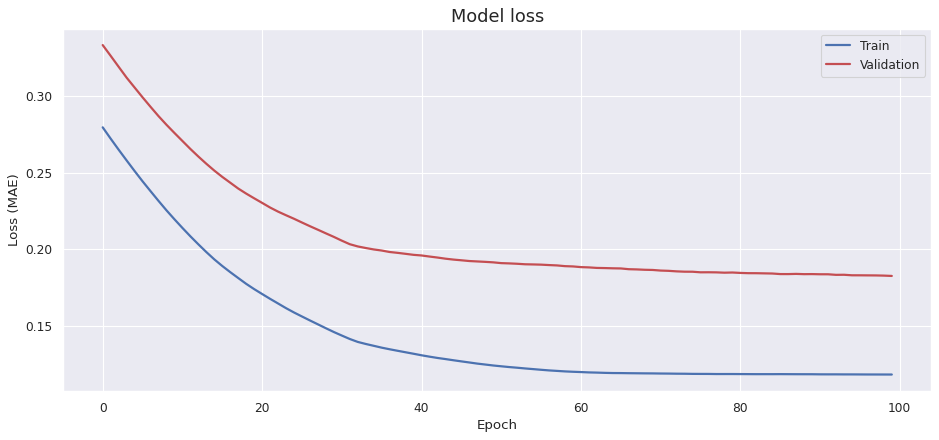

In [27]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.13)

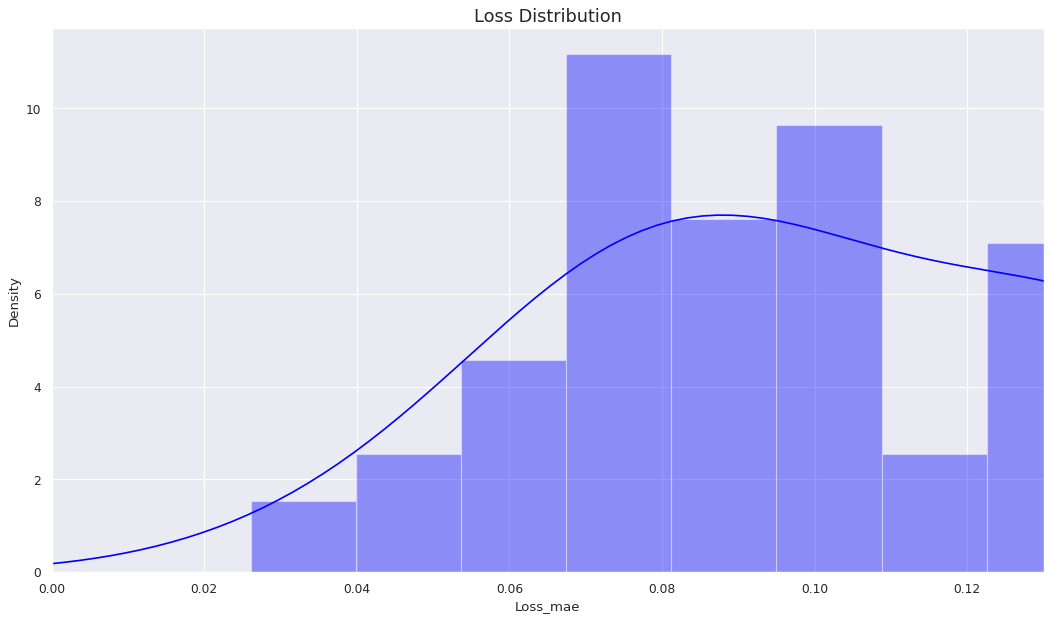

In [28]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.13])

In [29]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
X_train1 = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train1), axis = 1)
scored['Threshold'] = 0.11
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']

anomalies = scored[scored.Anomaly == True]
anomalies.head(20)

,Loss_mae,Threshold,Anomaly
Date,,,
2010-02-08,0.144695,0.11,True
2010-02-15,0.136469,0.11,True
2010-02-22,0.133640,0.11,True
2010-03-01,0.124423,0.11,True
2010-03-08,0.127798,0.11,True
2010-05-24,0.118826,0.11,True
2010-05-31,0.125529,0.11,True
2010-06-21,0.166180,0.11,True
2010-06-28,0.172822,0.11,True


(array([2093, 2140, 2192, 2235]), <a list of 4 Text major ticklabel objects>)

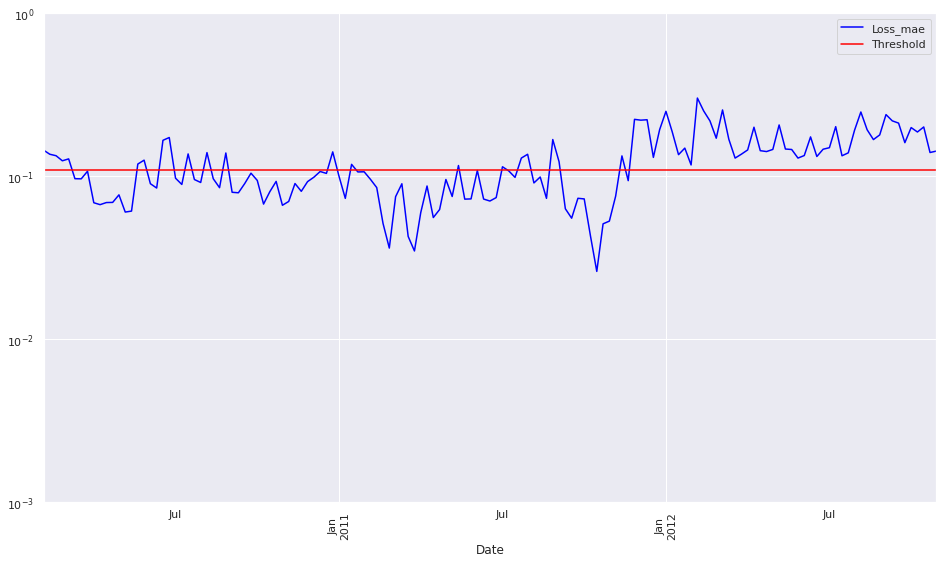

In [30]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-3,1e-0], color=['blue','red'])
plt.xticks(rotation=90)